# Human Protein Atlas Image Classification

## External Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.colors as col
import matplotlib.pyplot as plt
from importlib import reload
from skimage.exposure import equalize_adapthist,equalize_hist
from IPython.core.display import display, HTML
import seaborn as sns
from matplotlib.gridspec import GridSpec
from PIL import Image
from IPython.display import display
%matplotlib inline

## Local Imports

In [2]:
import protein_atlas as pa

Using TensorFlow backend.


## Output Formatting

In [3]:
# Notebook Settings
display(HTML("<style>.container { width:100% !important; }</style>"))

# Numpy Settings
np.set_printoptions(precision = 3, linewidth = 1e5, threshold = 1e5)

# Pandas Settings
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns",30)
pd.set_option("display.float_format","{:.2f}".format)

## Label Counts

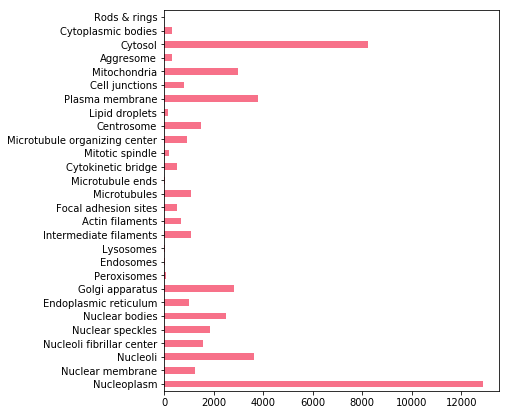

In [4]:
reload(pa); atlas = pa.ProteinAtlas()
fig, ax = plt.subplots(figsize=(6,7))
counts = atlas.labels.sum()
# counts.index = atlas.classes
# counts = counts.sort_values()
colors = sns.color_palette("husl",n_colors = 1)
counts.plot.barh(ax = ax, fontsize = 10, color = colors)

In [5]:
reload(pa); atlas = pa.ProteinAtlas()
ids = atlas.any([0,1,25]).sample(100).index
X, y = atlas.get_batch(ids)

In [6]:
X.shape

(100, 512, 512, 4)

## Input Pipeline

### Get a batch of images and labels

In [8]:
reload(pa)
atlas = pa.ProteinAtlas()
datagen = pa.ProteinAtlasGenerator(batch_size = 32, labels = atlas.all([5,1]))
x_batch, y_batch = datagen[0]

### Plot samples from a batch of images

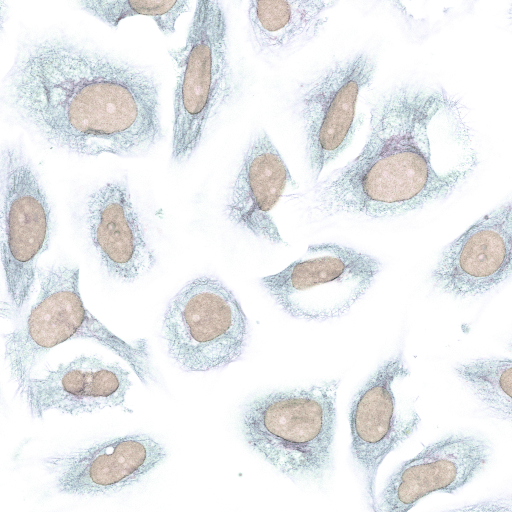

In [39]:
def make_cmap(i,**kwds):
    return sns.cubehelix_palette(
        start = i*3.0/atlas.n_channels,
        dark = 0, light = 1,
        gamma = 2.0, rot = 0, hue = 1,
        **kwds)
cmaps = [make_cmap(i, as_cmap = True) for i in range(atlas.n_channels)]

perm = np.random.permutation(x_batch.shape[0])
y = y_batch[perm]
X = x_batch[perm]

n_samples = 1
nrows = n_samples
for sample in range(n_samples):
    bands = [0] * atlas.n_channels
    img = np.zeros((atlas.height,atlas.width,4))
    for chan in range(atlas.n_channels):
        bands[chan] = cmaps[chan](X[sample,:,:,chan])
        img = img + bands[chan]/atlas.n_channels
        
    img = Image.fromarray(np.uint8(img*255))
    display(img)

## Neural Network

In [210]:
from keras.models import Sequential
from keras.layers import Conv2D, ReLU, Dense, Dropout
from keras.layers import Activation, Flatten, MaxPooling2D
from keras import backend as K
from keras.optimizers import SGD

model = Sequential()
model.add(Conv2D(32,(3,3), input_shape = (atlas.height, atlas.width, atlas.n_channels)))
model.add(Activation("relu"))
model.add(Conv2D(64,(3,3), input_shape = (atlas.height, atlas.width, atlas.n_channels)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss = "binary_crossentropy", optimizer = sgd, metrics=["accuracy"])

In [207]:
datagen = pa.ProteinAtlasGenerator(labels = atlas.labels.sample(500))
model.fit_generator(datagen)

Epoch 1/1


ValueError: Error when checking target: expected flatten_1 to have shape (8323200,) but got array with shape (28,)

## Correlation Between Labels

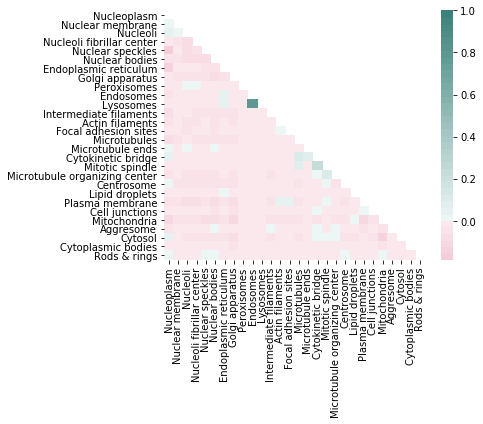

In [32]:
reload(pa)
atlas = pa.ProteinAtlas()
fig, ax = plt.subplots(figsize = (7,6))
cor = atlas.labels.corr()
cor.columns = atlas.classes
cor.index = atlas.classes
mask = np.zeros_like(cor.values)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(0,180,sep=1,n=64)
sns.heatmap(cor, ax = ax, cmap = cmap, mask = mask, center = 0)
plt.tight_layout()
plt.savefig("plots/corr.pdf")